# stock dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator
from opendataval.model.mlp import RegressionMLP

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment

### [Step 1-1] Define a DataFetcher from a registered dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to define a `DataFetcher` from a registered dataset. 

In [2]:
dataset_name = "stock"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
metric_name = "neg_mse"

fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(add_gauss_noise, noise_rate=noise_rate)
)

/burg/stats/users/yk3012/software/miniconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. The following code defines a multi-layer perceptron with two hidden layers. Each hidden layer has 25 nodes.

In [3]:
pred_model = RegressionMLP(fetcher.covar_dim[0], layers=2, hidden_dim=25)

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(mc_epochs=300)
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.001236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 297.10it/s]


Elapsed time LeaveOneOut(): 0:00:01.335908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 363.14it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:02.758125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 311.15it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:06.448211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 13714.57it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.013889
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.32it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.48it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.41it/s]

gr_stat=1.024045375855162
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:04.275535
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.46it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:02.100982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 367.00it/s]


Elapsed time AME(num_models=1000): 0:00:08.226062


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 280.81it/s]


Elapsed time DataOob(num_models=1000): 0:00:03.565649


Elapsed time LavaEvaluator(): 0:00:00.022919


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 209.39it/s]

Elapsed time RobustVolumeShapley(mc_epochs=300): 0:00:01.437030
CPU times: user 29.4 s, sys: 369 ms, total: 29.8 s
Wall time: 30.2 s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/stock_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.000000
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.151515
DVRL(rl_epochs=2000),0.126582
DataBanzhaf(num_models=1000),0.194444
DataOob(num_models=1000),0.105263
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.151515
InfluenceFunctionEval(num_models=1000),0.197802
KNNShapley(k_neighbors=50),0.000000
LavaEvaluator(),0.063158
LeaveOneOut(),0.136986


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

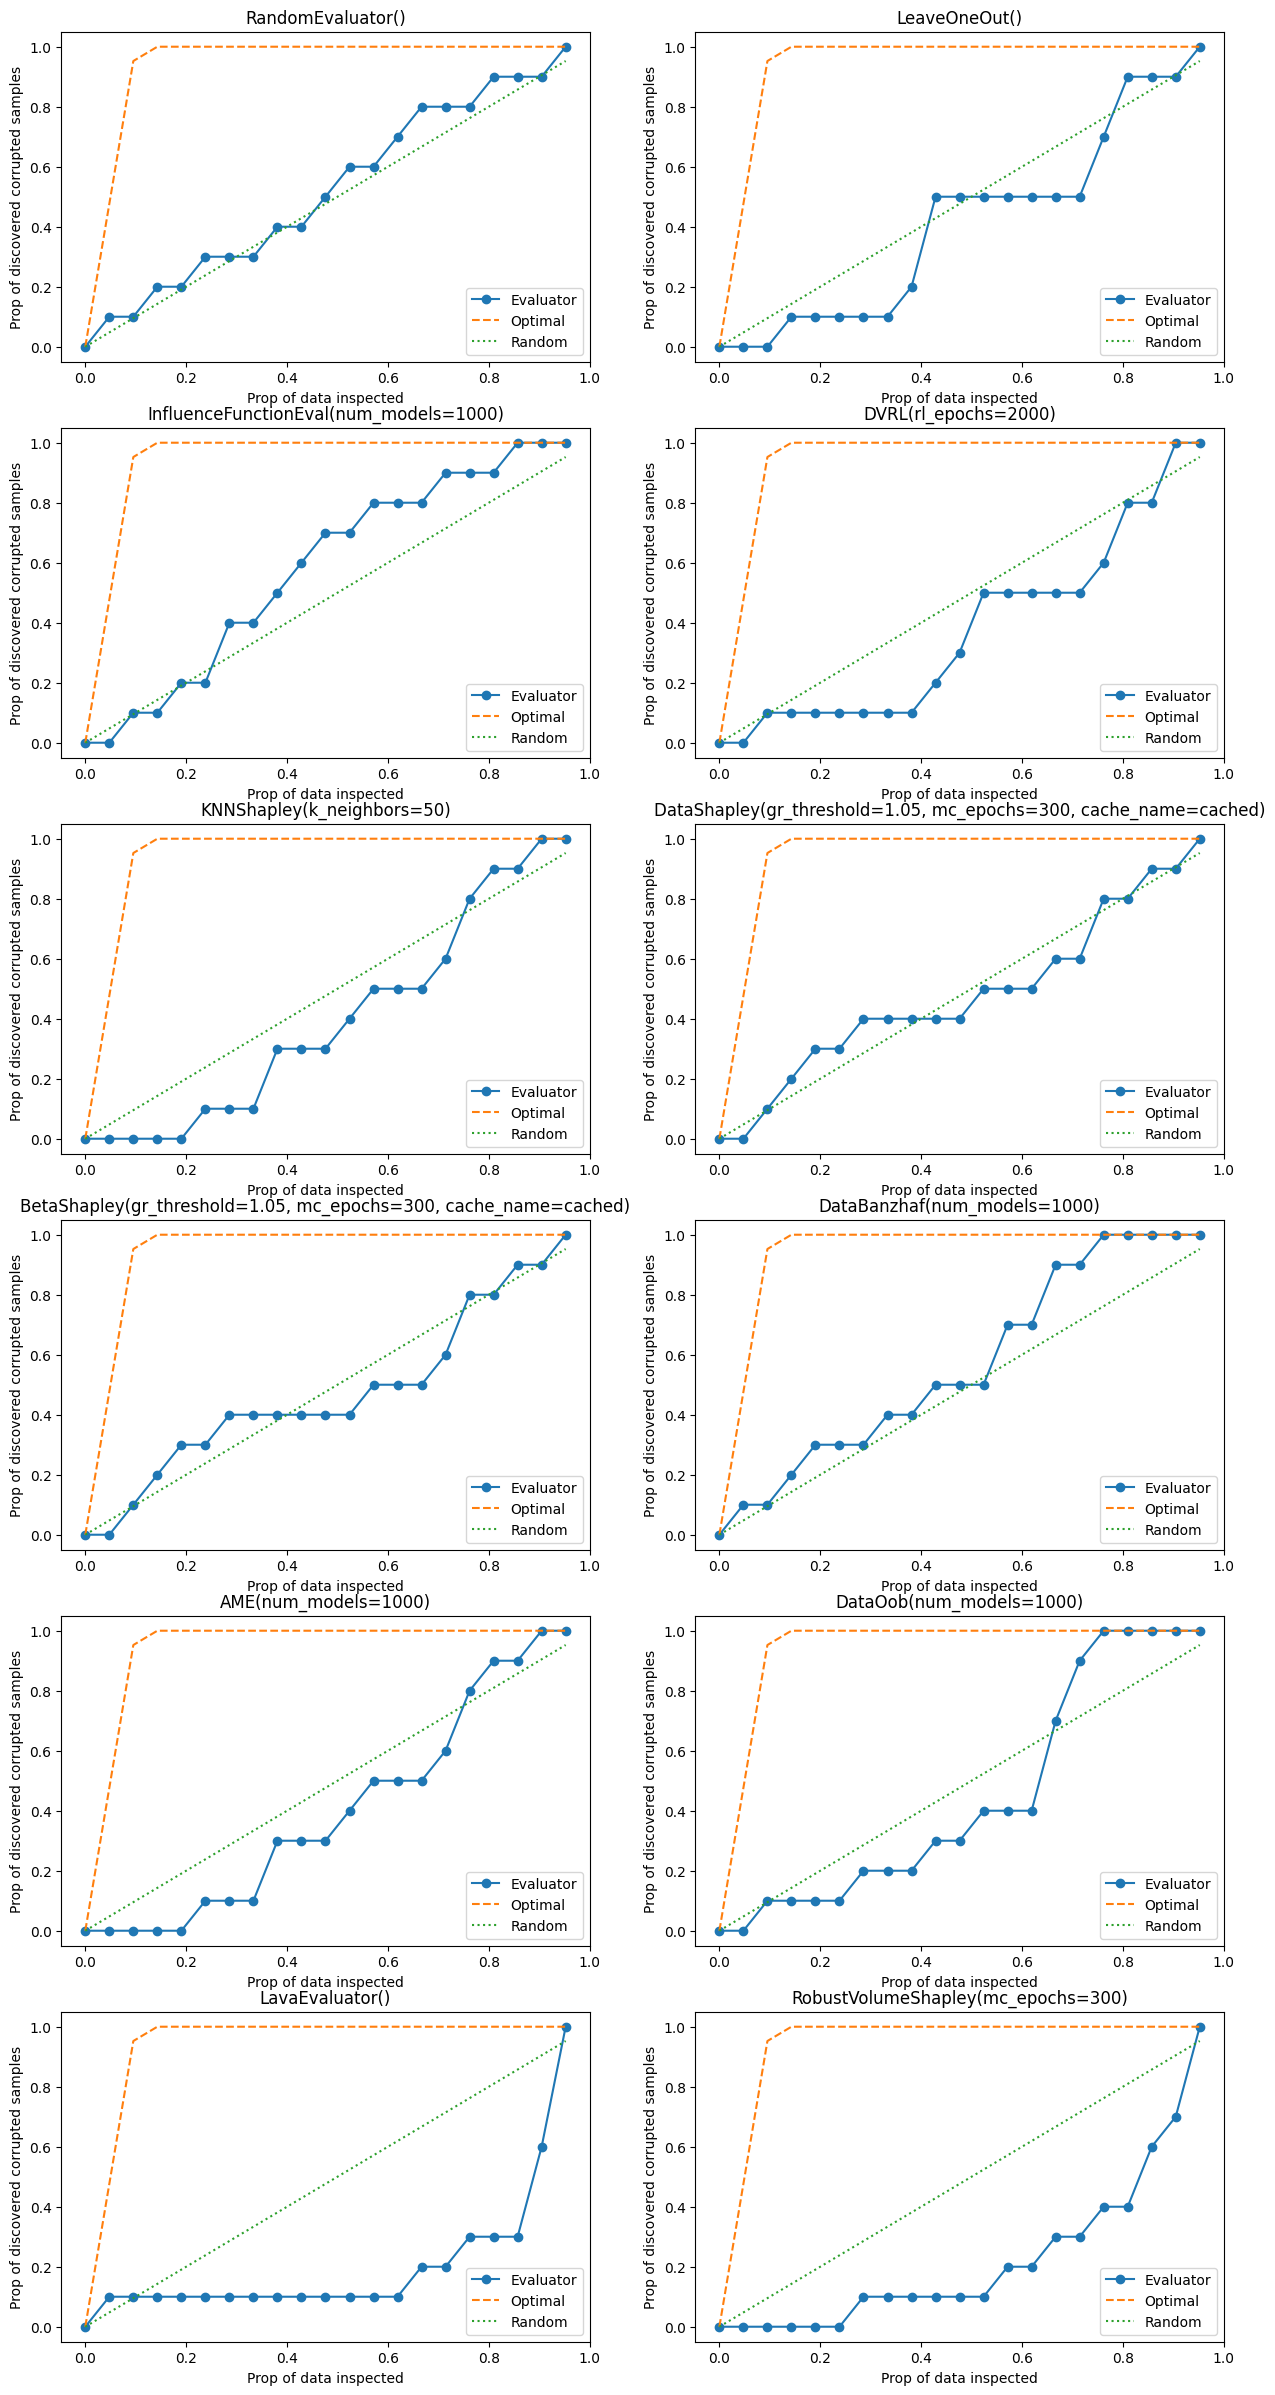

In [9]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

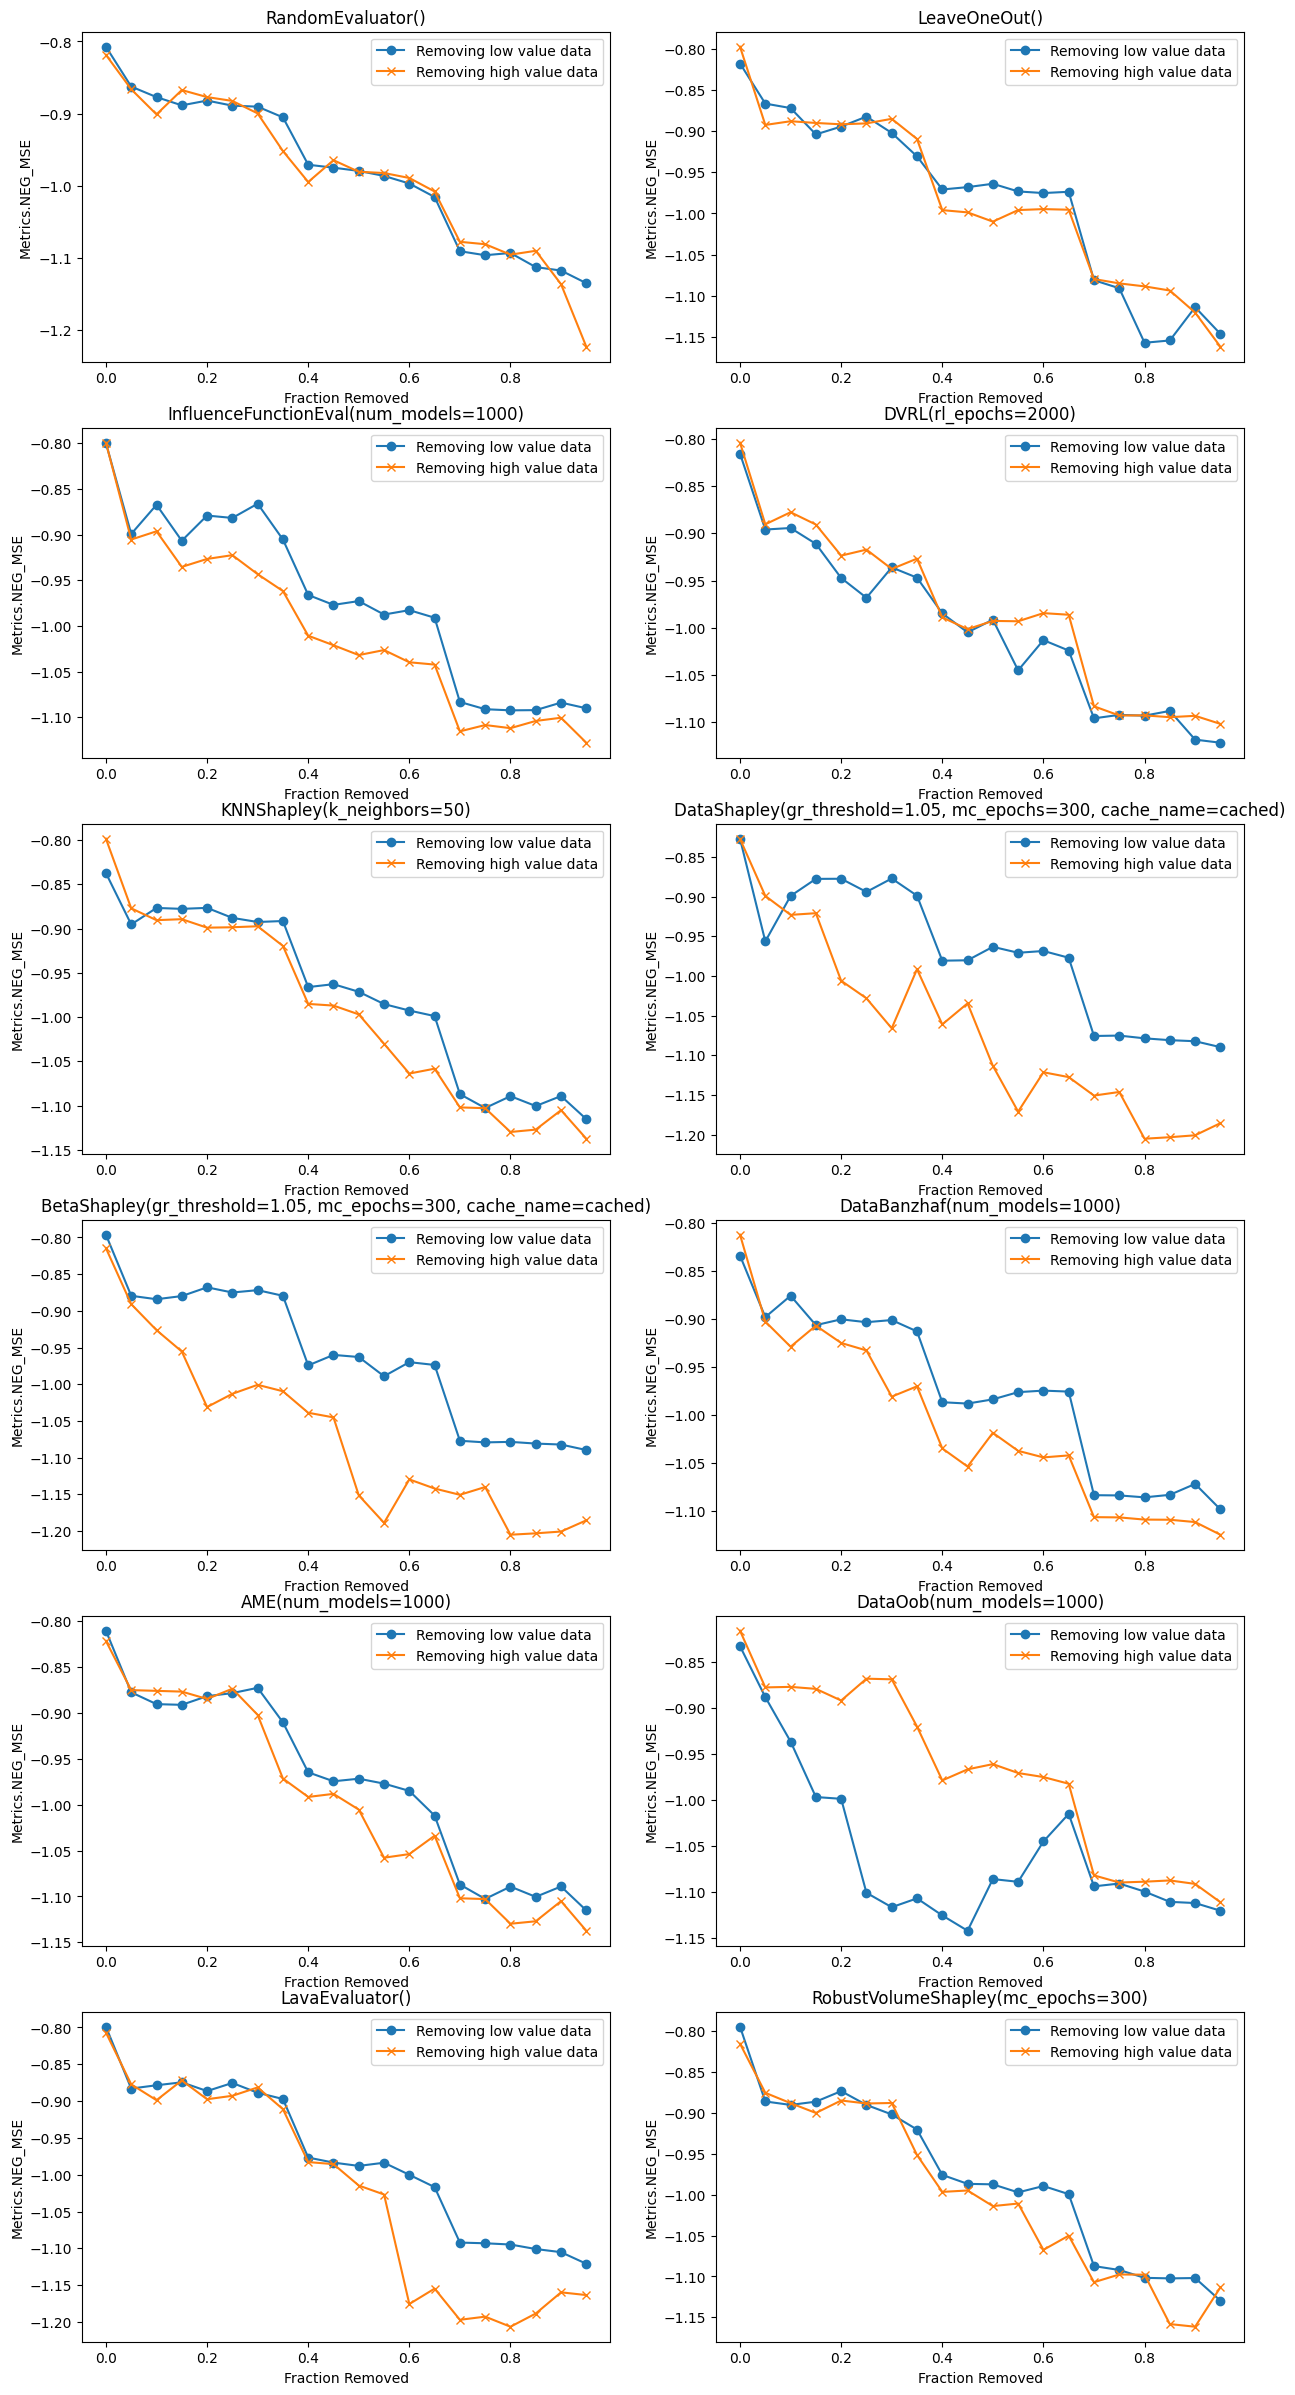

In [10]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.807261,-0.818595,0.0
RandomEvaluator(),-0.862551,-0.866279,0.05
RandomEvaluator(),-0.87714,-0.901143,0.1
RandomEvaluator(),-0.888583,-0.867375,0.15
RandomEvaluator(),-0.881965,-0.877136,0.2
...,...,...,...
RobustVolumeShapley(mc_epochs=300),-1.092043,-1.097545,0.75
RobustVolumeShapley(mc_epochs=300),-1.101648,-1.097796,0.8
RobustVolumeShapley(mc_epochs=300),-1.102328,-1.158229,0.85
RobustVolumeShapley(mc_epochs=300),-1.101898,-1.161464,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),10147,0.504383
RandomEvaluator(),25685,0.528827
RandomEvaluator(),22322,0.733476
RandomEvaluator(),55885,0.460236
RandomEvaluator(),10209,0.050794
...,...,...
RobustVolumeShapley(mc_epochs=300),55195,1129.509198
RobustVolumeShapley(mc_epochs=300),11758,1691.339543
RobustVolumeShapley(mc_epochs=300),31701,1219.034778
RobustVolumeShapley(mc_epochs=300),34886,498.790102
